# Applied Probabilities and Randomized Algorithms: Poisson Distribution & Poisson Process

Alviona Mancho | p3200098@aueb.gr

## Preliminaries

In [102]:
import random
import math
from collections import Counter
import matplotlib.pyplot as plt

In [52]:
def print_message(prob_str, expected_val, actual_val):
    print("Expected {0}={1:.5f} \t Actual {0}={2:.5f}".format(prob_str, expected_val, actual_val))

#### Function for the estimated probability of an event given a sample

In [46]:
def prob_event(sample, event):
    """Returns the estimated probability of event A in a sample, where A is a set of elementary events
    >>> sample = [1,2,4,2,2,3,5,3,6,1]
    >>> prob_event(sample, {2,3})
    0.5
    """
    size = len(sample)
    count = Counter(sample)
    count_event = sum(value for key, value in count.items() if key in event)
    prob_event = count_event/size
    return prob_event

#### Function for the estimated conditional expected value given a sample and a condition (event)

In [50]:
def cond_expected_value(sample, event):
    """Returns the estimated conditional expected value given a sample and the condition (event). If the event given is the empty set {}, then it returns the estimated expected value
    >>> sample = [1,2,3,4,5,6]
    >>> cond_expected_value(sample, {})
    3.5
    """
    size = len(sample)
    if(len(event) == 0):
        p_event = 1
    else:
        p_event = prob_event(sample, event)
    count = Counter(sample)
    
    cond_expected_val = sum(key*(value/size)/p_event for key, value in count.items() if len(event)==0 or key in event)
    return cond_expected_val

## Poisson Distribution

We are going to study the accuracy of approximating the Binomial distribution with an expected value of 1 (i.e., $p = 1/N$) by the Poisson distribution with an expected value of $\lambda = 1$. Specifically, for $N = 10, 20, 60, 100$ we will calculate the sum of absolute errors $\sum_{k=0}^{N} |b(k) - p(k)|$, where $b(k)$ is the probability mass function of the mentioned binomial distribution and $p(k)$ is that of the Poisson distribution with $\lambda = 1$.

- Let $X$~$Binomial(N, \frac{1}{N}) \Rightarrow E(X) = 1$<br>
 Then $b(k) = Pr(X = k) = \binom{Ν}{k} p^k (1-p)^{Ν-k}$

- Let $Y$~$Poisson(1) \Rightarrow E(Y) = 1$<br>
 Then $p(k) = Pr(Y = k) = \frac{e^{-\lambda} \lambda^k}{k!} = \frac{e^{-1}}{k!} $

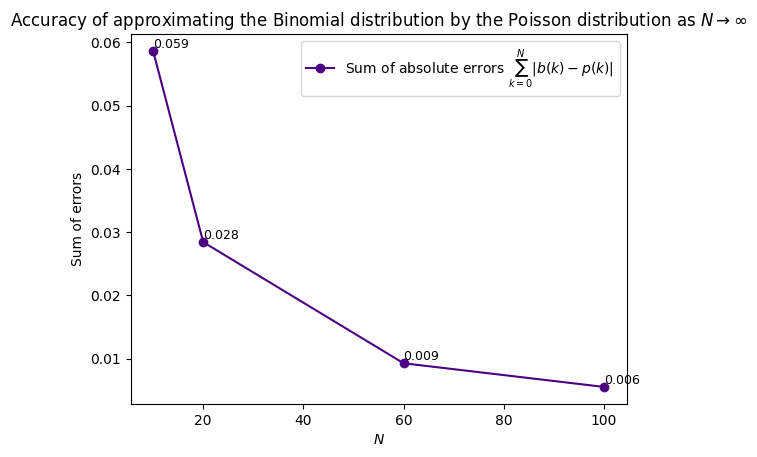

N=10:	0.05862
N=20:	0.02842
N=60:	0.00929
N=100:	0.00555


In [53]:
Ns = [10, 20, 60, 100]

errors = list()
for i in range(len(Ns)):
    N = Ns[i]
    p = 1/N

    error = 0
    for k in range(N):
        b_k = math.comb(N,k)*p**k*(1-p)**(N-k)
        p_k = 1/(math.e * math.factorial(k))
        error += abs(b_k - p_k)

    errors.append(error)

# Plot the errors
plt.plot(Ns, errors, 'o-', color='indigo', label=r'Sum of absolute errors $\sum_{k=0}^{N} |b(k) - p(k)|$')
plt.xlabel(r'$N$')
plt.ylabel('Sum of errors')
plt.title(r'Accuracy of approximating the Binomial distribution by the Poisson distribution as $N \rightarrow \infty$')

annotation_font = {'family': 'sans-serif', 'size': 9, 'weight': 'normal', 'color': 'black'}
for N, error in zip(Ns, errors):
    plt.text(N, error, f'{error:.3f}', ha='left', va='bottom', fontdict=annotation_font)

plt.legend()
plt.show()

# Print the errors
for N, error in zip(Ns, errors):
    print("N={0}:\t{1:.5f}".format(N, error))


We can easily observe that as $N$ increases, the sum of absolute errors decreases. This means that as the probability $p = \frac{1}{N} \rightarrow 0$ and the number of trials $N \rightarrow \infty$ for the Binomial distribution, the approximation from the Poisson distribution becomes better. This aligns with the conditions known from theory regarding when the Poisson distribution is a good approximation: we use the Poisson distribution when N is large (>100) and p is small (<0.04).

## Poisson Process simulation

We are going to simulate the "generation" of points based on the Poisson process with a rate of $λ$ points per unit of time. It is known that:
- Let $X$ = # of arrivals (points) in time $t =N(t)$. Then $X$~$Poisson(\lambda*t)$.
- Let $Y$ = inter-arrival time (time interval between any two consecutive arrivals). Then $Y$~$Exponential(\lambda)$

To do so:

1. For the given rate $\lambda$, generate inter-arrival times.
2. Calculate actual arrival times by summing the inter-arrival times.

Details for each step:

1. We need to generate inter-arrival times, which follow the exponential distribution with parameter $\lambda$.<br>
Therefore, we have to sample from $Y$~$Exponential(\lambda)$. Using the $U$~$Uniform(0,1)$, we have to simulate the exponential distribution. <br>
This means that we need a transformation $T$ s.t. $Y = T(U)$. <br><br>
Then, $F_Y(y)=Pr(Y \leq y)=Pr(T(U) \leq y)=Pr(U \leq T^{-1}(y))=T^{-1}(y)$. <br>
Hence, $F_Y(y)=T^{-1}(y) \Rightarrow T(y) = F_Y^{-1}(y)$. 

    - If $Y$~$Exponential(\lambda)$,  then $F(Y)=Pr(Y \leq y) = 1 - e^{-\lambda y} \Rightarrow F_Y^{-1} = \frac{-1}{\lambda}ln(1-y)$. 
    
    Therefore, we are going to sample $y$ from the $Uniform(0,1)$ and calculate the inter-arrival times $t^{inter}_i=\frac{-1}{\lambda}ln(1-y)$.

2. Given the sequence of inter-arrival times, all we have to do is calculate $t_1=t^{inter}_1$ and $t_i = \sum_{j=2}^{i-1}{t^{inter}_j}$ 

### Definition

In [138]:
def poisson_process(l, t, iters):
    """
    l: lambda parameter of the exponential distribution
    t: the time limit (measured in time units) up to which we are interested to generate points
    iters: maximum number of iterations to avoid infinite loop
    """

    t_arrivals = [0]    # The 0 element is used for convenience, we will remove this later
    
    while(t_arrivals[-1] < t and len(t_arrivals) < iters):
        # Step 1. Generate inter-arrival time
        y = random.random()
        t_inter = -1/l * math.log(1-y)

        # Step 2. Calculate actual arrival time
        t_arrivals.append(t_arrivals[-1] + t_inter)

    # Remove the 0 element and also remove the last element which definitely exceeds the time limit t 
    return t_arrivals[1:-1] 


### Simulation

We will run the simulation for rate of $\lambda=1$ point per unit of time and generate samples from $N(4)$, i.e., the number of points for a 4-unit time interval. Specifically, execute iters=1000 consecutive repetitions of this experiment and record their results. Then, based on these results: estimate some probabilities and the expected value regarding $N(4)$ and compare them with the theoretically predicted values:

$N(4)$~$Poisson(\lambda t=1*4=4)$

- $Pr[N(4)=k] = e^{-\lambda t}\frac{(\lambda t)^k}{k!} = e^{-4}\frac{(4)^k}{k!}$ (we will calculate the probabilities for k=1,..,5)

- $E[N(4)] = \lambda t = 1*4=4$

In [180]:
iters = 1000
l=1
t=4

num_of_points = list()

for iter in range(iters):
    poisson_process_seq = poisson_process(l, t, 50) # Max number of iterations set to 50 as Pr(N(4)>50)~0

    # Keep the number of arrivals (points) within [0,t] 
    num_of_points.append(len(poisson_process_seq))

# Estimate the probabilities Pr[N(t)=k] for k=1,..,5
for i in range(5):
    k = i+1
    print_message('Pr[N({0})={1}]'.format(t, i+1), math.e**(-l*t)*(l*t)**k/math.factorial(k), prob_event(num_of_points, {k}))

# Estimate the expected value E(N(t))
print_message('E[N(4)]', l*t, cond_expected_value(num_of_points, {}))


print('\nNote: Max N({0}) found in sample: {1} < 50 (= max iterations provided)'.format(t, max(num_of_points)))



Expected Pr[N(4)=1]=0.07326 	 Actual Pr[N(4)=1]=0.07200
Expected Pr[N(4)=2]=0.14653 	 Actual Pr[N(4)=2]=0.14500
Expected Pr[N(4)=3]=0.19537 	 Actual Pr[N(4)=3]=0.19700
Expected Pr[N(4)=4]=0.19537 	 Actual Pr[N(4)=4]=0.19100
Expected Pr[N(4)=5]=0.15629 	 Actual Pr[N(4)=5]=0.15000
Expected E[N(4)]=4.00000 	 Actual E[N(4)]=3.95900

Note: Max N(4) found in sample: 12 < 50 (= max iterations provided)
